In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow
from tensorflow import TensorSpec, float32, int32
from tensorflow import keras, data
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.data.experimental import load
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import optimizers

In [3]:
from tensorflow.keras.applications import Xception

In [4]:
# load helper funcs
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))
import run_multiclass_models_AWS as multiclass_funcs
import helper_funcs as my_funcs

In [5]:
batch_size = 32
img_size = 256
img_height = 256
img_width = 256
final_dense = 256

In [6]:
directory = '/home/ec2-user/data/all_US_unaugmented'

In [7]:
# X_train = image_dataset_from_directory(
#     directory, labels='inferred', class_names=None, label_mode='categorical',
#     color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42,
#     validation_split=0.25, subset='training', interpolation='bilinear', follow_links=True
#     )

In [8]:
10253-7690

2563

In [9]:
X_train, X_test, X_holdout = multiclass_funcs.load_data_from_dir(directory, batch_size, img_size, 2563)

Found 10253 files belonging to 3 classes.
Using 7690 files for training.
Found 10253 files belonging to 3 classes.
Using 2563 files for validation.
 holdout size: 512, test size: 2051


In [16]:
X_train.class_names

['Established Campground', 'Informal Campsite', 'Wild Camping']

In [10]:
class_names, class_weights = multiclass_funcs.get_class_weights(X_train)

In [11]:
num_classes = len(X_train.class_names)
epochs = 2 # number of passes through the entire train dataset before weights "final"
AUTOTUNE = data.experimental.AUTOTUNE
nb_filters = 32    # number of convolutional filters to use - want 1 for each "feature" you think exists in images if more, more parameters
pool_size = (2, 2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (2, 2)  # convolutional kernel size, slides over image to learn features

In [12]:
X_train, X_test = multiclass_funcs.prep_data(X_train, X_test, batch_size=batch_size)

In [14]:
# model = multiclass_funcs.build_model(num_classes, nb_filters, kernel_size, pool_size, img_height, img_width, final_dense)

In [13]:
def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        
        # add new head
        model = layers.GlobalAveragePooling2D()(model)
        # add fully connected?
        # x = Dense(1024, activation='relu')(x)
#         layers.Dropout(0.3),
        predictions = layers.Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model
    
Xception_model = create_transfer_model(input_size=(256,256,3), n_categories=num_classes)

In [14]:
Xception_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [15]:
def print_model_properties(model, indices = 0):
     for i, layer in enumerate(model.layers[indices:]):
        print("Layer {} | Name: {} | Trainable: {}".format(i+indices, layer.name, layer.trainable))
        
print_model_properties(Xception_model)

Layer 0 | Name: input_1 | Trainable: True
Layer 1 | Name: block1_conv1 | Trainable: True
Layer 2 | Name: block1_conv1_bn | Trainable: True
Layer 3 | Name: block1_conv1_act | Trainable: True
Layer 4 | Name: block1_conv2 | Trainable: True
Layer 5 | Name: block1_conv2_bn | Trainable: True
Layer 6 | Name: block1_conv2_act | Trainable: True
Layer 7 | Name: block2_sepconv1 | Trainable: True
Layer 8 | Name: block2_sepconv1_bn | Trainable: True
Layer 9 | Name: block2_sepconv2_act | Trainable: True
Layer 10 | Name: block2_sepconv2 | Trainable: True
Layer 11 | Name: block2_sepconv2_bn | Trainable: True
Layer 12 | Name: conv2d | Trainable: True
Layer 13 | Name: block2_pool | Trainable: True
Layer 14 | Name: batch_normalization | Trainable: True
Layer 15 | Name: add | Trainable: True
Layer 16 | Name: block3_sepconv1_act | Trainable: True
Layer 17 | Name: block3_sepconv1 | Trainable: True
Layer 18 | Name: block3_sepconv1_bn | Trainable: True
Layer 19 | Name: block3_sepconv2_act | Trainable: True
La

In [16]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

In [17]:
change_trainable_layers(Xception_model, 132)        
print_model_properties(Xception_model, 130)

Layer 130 | Name: block14_sepconv2_bn | Trainable: False
Layer 131 | Name: block14_sepconv2_act | Trainable: False
Layer 132 | Name: global_average_pooling2d | Trainable: True
Layer 133 | Name: dense | Trainable: True


In [18]:
slow_adam = optimizers.Adam(learning_rate=0.0001)

In [19]:
Xception_model.compile(optimizer=slow_adam,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [20]:
my_callbacks = [
    callbacks.EarlyStopping(patience=5),
    callbacks.ModelCheckpoint(
                        filepath='../model_data/data/tensorboard_models/Xception.{epoch:02d}-{val_loss:.2f}.h5', 
                        monitor='val_loss', 
                        verbose=1, 
                        save_best_only=True,
                        save_weights_only=False, 
                        mode='auto', 
                        save_freq='epoch', 
                        options=None),
    callbacks.TensorBoard(log_dir=f'../model_data/data/Xception_logs_training{0}',
                          histogram_freq=2,
                          write_graph=True,
                          write_images=True),
]

In [21]:
def open_and_compile(model, layer_index):
    change_trainable_layers(model, layer_index)        
    print_model_properties(model, layer_index-2)
    model.compile(optimizer=slow_adam,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model

In [33]:
def train_more(model, epochs):
    global train_num
    history = model.fit(
            X_train,
            validation_data = X_test,
            epochs = epochs,
            class_weight = class_weights,
            verbose = 2,
            callbacks= [
    callbacks.EarlyStopping(patience=5),
    callbacks.ModelCheckpoint(
                        filepath='../model_data/data/tensorboard_models/Xception.{epoch:02d}-{val_loss:.2f}.h5', 
                        monitor='val_loss', 
                        verbose=1, 
                        save_best_only=True,
                        save_weights_only=False, 
                        mode='auto', 
                        save_freq='epoch', 
                        options=None),
    callbacks.TensorBoard(log_dir=f'../model_data/data/Xception_logs_training{train_num}',
                          histogram_freq=2,
                          write_graph=True,
                          write_images=True),
                        ]
                        )
    train_num += 1
    return history, model

In [27]:
Xception_model = open_and_compile(Xception_model, 132)

Layer 130 | Name: block14_sepconv2_bn | Trainable: False
Layer 131 | Name: block14_sepconv2_act | Trainable: False
Layer 132 | Name: global_average_pooling2d | Trainable: True
Layer 133 | Name: dense | Trainable: True


In [38]:
%load_ext tensorboard
%tensorboard --logdir ../model_data/data/Xception_logs_training4

In [34]:
train_num = 1

In [23]:
history = Xception_model.fit(
            X_train,
            validation_data = X_test,
            epochs = epochs,
            class_weight = class_weights,
            verbose = 2,
            callbacks=my_callbacks
)

Epoch 1/2
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch 00001: val_loss improved from inf to 1.10688, saving model to ../model_data/data/tensorboard_models/Xception.01-1.11.h5
241/241 - 132s - loss: 2987.9998 - accuracy: 0.3815 - val_loss: 1.1069 - val_accuracy: 0.4427
Epoch 2/2

Epoch 00002: val_loss improved from 1.10688 to 1.10542, saving model to ../model_data/data/tensorboard_models/Xception.02-1.11.h5
241/241 - 123s - loss: 2796.2261 - accuracy: 0.4257 - val_loss: 1.1054 - val_accuracy: 0.4442


In [28]:
history, Xception_model = train_more(Xception_model, 20)

Epoch 1/20

Epoch 00001: val_loss improved from 1.10542 to 1.08491, saving model to ../model_data/data/tensorboard_models/Xception.01-1.08.h5
241/241 - 127s - loss: 2780.1465 - accuracy: 0.4303 - val_loss: 1.0849 - val_accuracy: 0.4417
Epoch 2/20

Epoch 00002: val_loss improved from 1.08491 to 1.06079, saving model to ../model_data/data/tensorboard_models/Xception.02-1.06.h5
241/241 - 122s - loss: 2713.8191 - accuracy: 0.4572 - val_loss: 1.0608 - val_accuracy: 0.4690
Epoch 3/20

Epoch 00003: val_loss improved from 1.06079 to 1.05373, saving model to ../model_data/data/tensorboard_models/Xception.03-1.05.h5
241/241 - 126s - loss: 2684.0664 - accuracy: 0.4698 - val_loss: 1.0537 - val_accuracy: 0.4734
Epoch 4/20

Epoch 00004: val_loss did not improve from 1.05373
241/241 - 123s - loss: 2666.9946 - accuracy: 0.4797 - val_loss: 1.0585 - val_accuracy: 0.4739
Epoch 5/20

Epoch 00005: val_loss did not improve from 1.05373
241/241 - 126s - loss: 2657.3096 - accuracy: 0.4834 - val_loss: 1.0549 -

In [29]:
Xception_model = open_and_compile(Xception_model, 126)

Layer 124 | Name: batch_normalization_3 | Trainable: False
Layer 125 | Name: add_11 | Trainable: False
Layer 126 | Name: block14_sepconv1 | Trainable: True
Layer 127 | Name: block14_sepconv1_bn | Trainable: True
Layer 128 | Name: block14_sepconv1_act | Trainable: True
Layer 129 | Name: block14_sepconv2 | Trainable: True
Layer 130 | Name: block14_sepconv2_bn | Trainable: True
Layer 131 | Name: block14_sepconv2_act | Trainable: True
Layer 132 | Name: global_average_pooling2d | Trainable: True
Layer 133 | Name: dense | Trainable: True


In [30]:
history, Xception_model = train_more(Xception_model, 30)

Epoch 1/30

Epoch 00001: val_loss did not improve from 1.03725
241/241 - 135s - loss: 2649.7419 - accuracy: 0.4897 - val_loss: 1.0486 - val_accuracy: 0.4544
Epoch 2/30

Epoch 00002: val_loss improved from 1.03725 to 1.02156, saving model to ../model_data/data/tensorboard_models/Xception.02-1.02.h5
241/241 - 130s - loss: 2541.6245 - accuracy: 0.5466 - val_loss: 1.0216 - val_accuracy: 0.4851
Epoch 3/30

Epoch 00003: val_loss did not improve from 1.02156
241/241 - 134s - loss: 2493.0688 - accuracy: 0.5683 - val_loss: 1.0452 - val_accuracy: 0.4676
Epoch 4/30

Epoch 00004: val_loss improved from 1.02156 to 1.01161, saving model to ../model_data/data/tensorboard_models/Xception.04-1.01.h5
241/241 - 130s - loss: 2452.7239 - accuracy: 0.5876 - val_loss: 1.0116 - val_accuracy: 0.5139
Epoch 5/30

Epoch 00005: val_loss improved from 1.01161 to 0.98988, saving model to ../model_data/data/tensorboard_models/Xception.05-0.99.h5
241/241 - 134s - loss: 2422.3518 - accuracy: 0.6061 - val_loss: 0.9899 -

In [35]:
Xception_model = open_and_compile(Xception_model, 116)

Layer 114 | Name: block12_sepconv3_bn | Trainable: False
Layer 115 | Name: add_10 | Trainable: False
Layer 116 | Name: block13_sepconv1_act | Trainable: True
Layer 117 | Name: block13_sepconv1 | Trainable: True
Layer 118 | Name: block13_sepconv1_bn | Trainable: True
Layer 119 | Name: block13_sepconv2_act | Trainable: True
Layer 120 | Name: block13_sepconv2 | Trainable: True
Layer 121 | Name: block13_sepconv2_bn | Trainable: True
Layer 122 | Name: conv2d_3 | Trainable: True
Layer 123 | Name: block13_pool | Trainable: True
Layer 124 | Name: batch_normalization_3 | Trainable: True
Layer 125 | Name: add_11 | Trainable: True
Layer 126 | Name: block14_sepconv1 | Trainable: True
Layer 127 | Name: block14_sepconv1_bn | Trainable: True
Layer 128 | Name: block14_sepconv1_act | Trainable: True
Layer 129 | Name: block14_sepconv2 | Trainable: True
Layer 130 | Name: block14_sepconv2_bn | Trainable: True
Layer 131 | Name: block14_sepconv2_act | Trainable: True
Layer 132 | Name: global_average_pooling

In [36]:
history, Xception_model = train_more(Xception_model, 30)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.09596, saving model to ../model_data/data/tensorboard_models/Xception.01-1.10.h5
241/241 - 148s - loss: 2593.1003 - accuracy: 0.5338 - val_loss: 1.0960 - val_accuracy: 0.3364
Epoch 2/30

Epoch 00002: val_loss improved from 1.09596 to 1.05549, saving model to ../model_data/data/tensorboard_models/Xception.02-1.06.h5
241/241 - 141s - loss: 2457.4207 - accuracy: 0.5908 - val_loss: 1.0555 - val_accuracy: 0.5383
Epoch 3/30

Epoch 00003: val_loss improved from 1.05549 to 0.94998, saving model to ../model_data/data/tensorboard_models/Xception.03-0.95.h5
241/241 - 144s - loss: 2386.7280 - accuracy: 0.6217 - val_loss: 0.9500 - val_accuracy: 0.5807
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.94998
241/241 - 140s - loss: 2310.0164 - accuracy: 0.6537 - val_loss: 0.9638 - val_accuracy: 0.5646
Epoch 5/30

Epoch 00005: val_loss did not improve from 0.94998
241/241 - 144s - loss: 2256.0007 - accuracy: 0.6746 - val_loss: 0.9610 - val

In [37]:
Xception_model = open_and_compile(Xception_model, 106)
history, Xception_model = train_more(Xception_model, 30)

Layer 104 | Name: block11_sepconv3_bn | Trainable: False
Layer 105 | Name: add_9 | Trainable: False
Layer 106 | Name: block12_sepconv1_act | Trainable: True
Layer 107 | Name: block12_sepconv1 | Trainable: True
Layer 108 | Name: block12_sepconv1_bn | Trainable: True
Layer 109 | Name: block12_sepconv2_act | Trainable: True
Layer 110 | Name: block12_sepconv2 | Trainable: True
Layer 111 | Name: block12_sepconv2_bn | Trainable: True
Layer 112 | Name: block12_sepconv3_act | Trainable: True
Layer 113 | Name: block12_sepconv3 | Trainable: True
Layer 114 | Name: block12_sepconv3_bn | Trainable: True
Layer 115 | Name: add_10 | Trainable: True
Layer 116 | Name: block13_sepconv1_act | Trainable: True
Layer 117 | Name: block13_sepconv1 | Trainable: True
Layer 118 | Name: block13_sepconv1_bn | Trainable: True
Layer 119 | Name: block13_sepconv2_act | Trainable: True
Layer 120 | Name: block13_sepconv2 | Trainable: True
Layer 121 | Name: block13_sepconv2_bn | Trainable: True
Layer 122 | Name: conv2d_3 

In [39]:
Xception_model = open_and_compile(Xception_model, 96)
history, Xception_model = train_more(Xception_model, 30)

Layer 94 | Name: block10_sepconv3_bn | Trainable: False
Layer 95 | Name: add_8 | Trainable: False
Layer 96 | Name: block11_sepconv1_act | Trainable: True
Layer 97 | Name: block11_sepconv1 | Trainable: True
Layer 98 | Name: block11_sepconv1_bn | Trainable: True
Layer 99 | Name: block11_sepconv2_act | Trainable: True
Layer 100 | Name: block11_sepconv2 | Trainable: True
Layer 101 | Name: block11_sepconv2_bn | Trainable: True
Layer 102 | Name: block11_sepconv3_act | Trainable: True
Layer 103 | Name: block11_sepconv3 | Trainable: True
Layer 104 | Name: block11_sepconv3_bn | Trainable: True
Layer 105 | Name: add_9 | Trainable: True
Layer 106 | Name: block12_sepconv1_act | Trainable: True
Layer 107 | Name: block12_sepconv1 | Trainable: True
Layer 108 | Name: block12_sepconv1_bn | Trainable: True
Layer 109 | Name: block12_sepconv2_act | Trainable: True
Layer 110 | Name: block12_sepconv2 | Trainable: True
Layer 111 | Name: block12_sepconv2_bn | Trainable: True
Layer 112 | Name: block12_sepconv3

In [40]:
# Xception_model.save('../model_data/Xception_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../model_data/Xception_model/assets


In [17]:
from tensorflow.keras.models import Sequential, load_model
Xception_model = load_model('/Users/pault/Desktop/models_from_aws/Xception_model')
directory = '../data/symlink_data/wild_est_informal_un_aug'


Found 10253 files belonging to 3 classes.
Using 7690 files for training.
Found 10253 files belonging to 3 classes.
Using 2563 files for validation.
 holdout size: 512, test size: 2051


In [24]:
X_train, X_test, X_holdout = multiclass_funcs.load_data_from_dir(directory, 32, 256, 2563)

Found 10253 files belonging to 3 classes.
Using 7690 files for training.
Found 10253 files belonging to 3 classes.
Using 2563 files for validation.
 holdout size: 512, test size: 2051


In [28]:
class_names = X_train.class_names

In [25]:
X_holdout1 = X_holdout.batch(32)

In [26]:
X_holdout1

<BatchDataset shapes: ((None, 256, 256, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [27]:
y, predictions, y_pred = multiclass_funcs.get_preds(Xception_model, X_holdout1)

16/16 - 35s


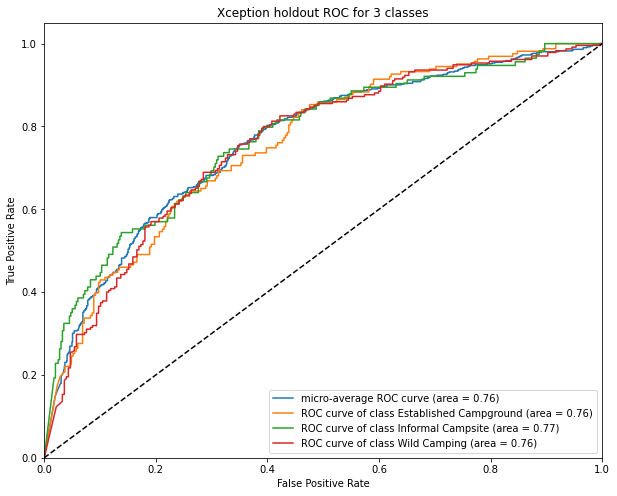

In [34]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax = multiclass_funcs.multiclass_ROC_plot(class_names, y, predictions, ax, 'Xception holdout ROC for 3 classes')
plt.savefig('../model_data/plots/Xception_ROC_multiclass_fixed.png');

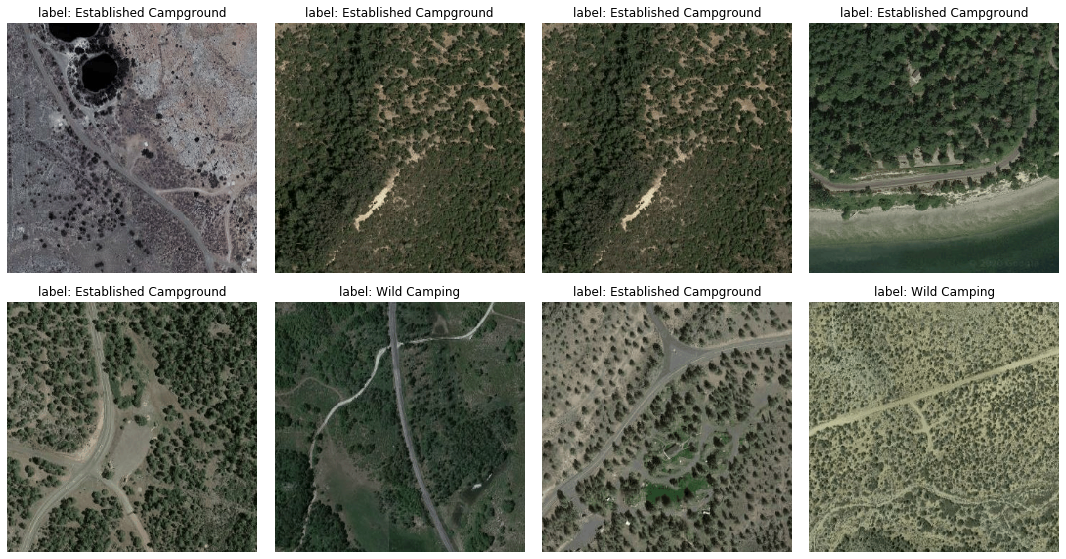

In [45]:
# check model
num_samples = 10
figsize = (15,8)
my_funcs.plot_example_imgs(X_test, class_names, figsize, num_samples);
# plt.savefig('../images/example_imgs.png') 

In [30]:
def compute_confusion_matrix(y_true_class, y_pred_class, class_names):
    '''
    computes confusion matrix and returns as array
    requires sklearn confusion_matrix
    '''
    confmat = confusion_matrix(y_true_class.argmax(axis=1), y_pred_class.argmax(axis=1), normalize='all') #, labels=class_names)
#     confmat = confmat / confmat.sum(0).astype(float)
    return confmat

In [31]:
confmat = compute_confusion_matrix(y, predictions, class_names)
confmat

array([[0.20703125, 0.03125   , 0.08007812],
       [0.0703125 , 0.1171875 , 0.03515625],
       [0.12109375, 0.07226562, 0.265625  ]])

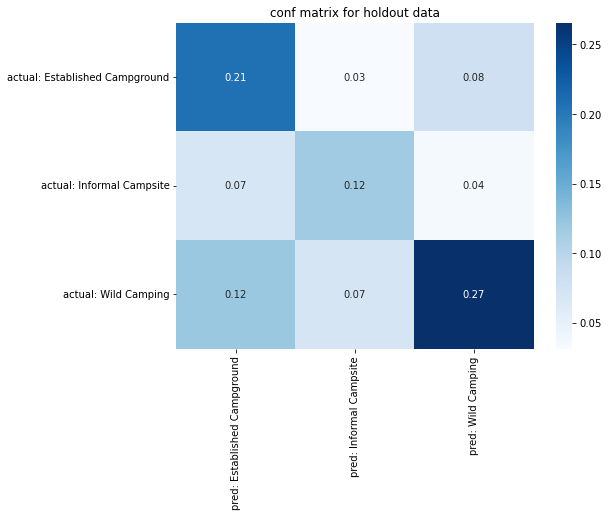

In [33]:
xlabels = [f'actual: {x}' for x in class_names] 
ylabels = [f'pred: {x}' for x in class_names] 

fig, ax = plt.subplots(1, figsize = (8,6))
ax = my_funcs.plot_conf_matrix(confmat, ax, xlabels, ylabels, 'conf matrix for holdout data')
plt.savefig('../model_data/plots/Xception_confmat_multiclass_fixed.png');